In [ ]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import ipywidgets as widgets

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

Populating the interactive namespace from numpy and matplotlib


Based on this TensorFlow Probability Tutorial
https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model

# Wolf Packs

  * Suppose we have observations of wolves in a certain area. 
  * We think they come from three different packs
  * Assume the wolves will tend to stay close to their den
  * We want to know where the den is for each of the three packs
  * We want to know what the relative size of each pack is

In [ ]:
Nobservations = 200
sigma = 1.
den1 = array([-2., -2.])
den2 = array([0., 0.])
den3 = array([2., 2.])
dens_gt = stack([den1, den2, den3], 0)
relative_sizes = array([0.5, 0.2, 0.3])
u = rand(Nobservations)
den_id = searchsorted(relative_sizes.cumsum(), u)
X = normal(dens_gt[den_id], sigma)


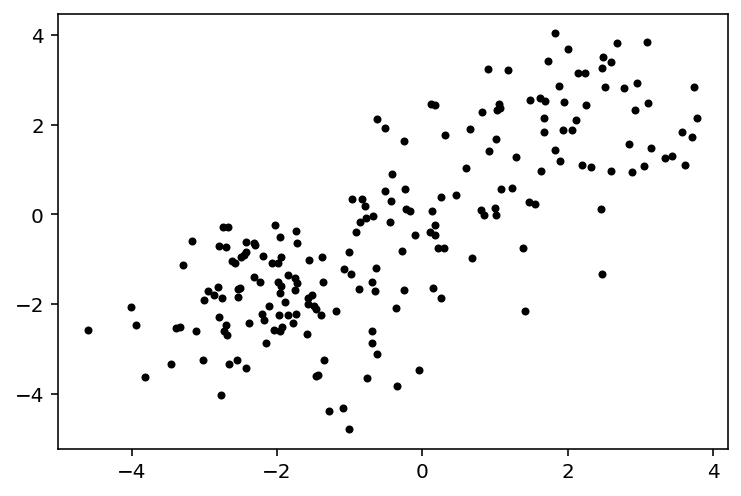

In [ ]:
plot(X[:, 0], X[:, 1], '.k')

For $i=1, \ldots, N_{obs}$,
\begin{align*}
 \theta &\sim \text{Dirichlet}(\alpha) \\
 \mu[n] &\sim \text{Normal}(0, 3), \quad n=1,2,3 \\
 \sigma &= 1 \\
 n_i &\sim \text{Categorical}(\theta) \\
 X_i & \sim \text{Normal}(\mu[n_i], \sigma)
\end{align*}

In [ ]:
@tf.function()
def log_generative_density(den_locations, pack_sizes):
    sigma = float64([1.])
    _log_density_den_locations = tfd.Normal(
        loc=float64([0., 0.]), scale=3.).log_prob(den_locations) ## prior
    log_density_den_locations = tf.reduce_sum(_log_density_den_locations)
    log_density_pack_sizes = tfd.Dirichlet(
        concentration=ones(3)/10.).log_prob(pack_sizes) ## prior
    _log_density_X = tf.reduce_sum(
        tfd.Normal(
            loc=den_locations[None, ...], # see broadcasting example below
            scale=sigma).log_prob(
                X[:, None, :]), ## X: Nobs, 2
        axis=-1)
    logits = tf.math.log(pack_sizes)[None, :]
    log_density_X = tf.reduce_sum(
        tf.reduce_logsumexp(_log_density_X + logits, axis=-1))
    return log_density_X + log_density_pack_sizes + log_density_den_locations

In [ ]:
## quick broadcasting example
a = array([1, 2])[None, :]
b = array([2, 1, 0])[:, None]
print(a.shape)
print(b.shape)
a*b

(1, 2)
(3, 1)


array([[2, 4],
       [1, 2],
       [0, 0]])

In [ ]:
unconstraining_bijectors = [
    tfp.bijectors.Identity(),
    tfp.bijectors.SoftmaxCentered()]
    
@tf.function()
def sample(initial_state):
    theta = tfp.mcmc.sample_chain(
        num_results=2000,
        num_burnin_steps=1000,
        current_state=initial_state,
        kernel=tfp.mcmc.SimpleStepSizeAdaptation(
            tfp.mcmc.TransformedTransitionKernel(
                inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn=log_generative_density,
                    step_size=0.1,
                    num_leapfrog_steps=5),
                bijector=unconstraining_bijectors),
            num_adaptation_steps=600),
        trace_fn=None)
    return theta
p0 = rand(3)
p0 /= p0.sum(axis=-1)#[:, None]
mu0 = normal(0, .1, [3, 2])
theta = sample([mu0, p0])
den_locations = array(theta[0])
relative_den_sizes = array(theta[1])

In [ ]:
tfp.mcmc.effective_sample_size(theta)

[<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
 array([[ 258.73364781,  307.75774281],
        [1253.53583388, 1316.02004721],
        [2000.        , 2000.        ]])>,
 <tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 192.01655107,  257.32139722, 1539.80757043])>]

In [ ]:
array(theta[0][:, :]).mean(axis=0)

array([[-1.98285888, -1.94690168],
       [ 2.09345458,  2.17930629],
       [ 0.18361668,  0.05338722]])

In [ ]:
array(theta[1][:, :]).mean(axis=0)

array([0.50685986, 0.28712567, 0.20601448])

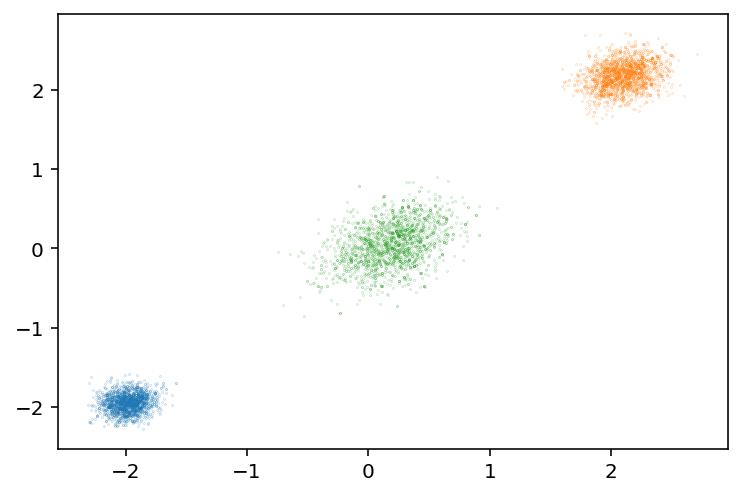

In [ ]:
plot(den_locations[:, 0, 0], den_locations[:, 0, 1], '.', ms=0.2)
plot(den_locations[:, 1, 0], den_locations[:, 1, 1], '.', ms=0.2)
plot(den_locations[:, 2, 0], den_locations[:, 2, 1], '.', ms=0.2)
# ylim(-5, 5)
# xlim(-5, 5);

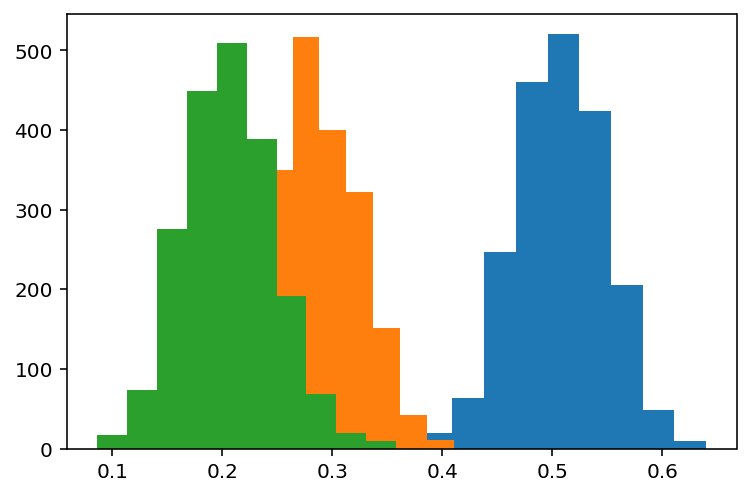

In [ ]:
hist(relative_den_sizes[:, 0])
hist(relative_den_sizes[:, 1])
hist(relative_den_sizes[:, 2]);